# Project 1: Arduino as a Laboratory Interface

The purpose of this project is twofold:

1. to familiarize the students with some of the tools we'll be using in this course: the Arduino compiler, simulator and microcontroller, electronic breadboards, "C", "python" and jupyter notebooks, AND

2. to build a simple circuit that enables us to study the behvior of an LED.



What are we actually doing (step-by-step)?
    1. Set up the circuit with unknown resistors shown below and program the Arduino to collect data as we adjust the driving current through the diode.
    2. Run the program to collect voltage vs. time data from the Arduino.
    3. Analyze the collected data using Jupiter and compare results vs expectations.
    4. Carry out the Statistical Exercises.

## Circuit Schematic & Function
In order to collect the data that will allow us to study the behavior of the LED, we built this simple circuit that consists of:
 * an Arduino, which is the programmable circuit board run by the computer.
 * A capacitor of 20 microFarad that stores electrical energy connected to R1 by its Anode and to ground by its Cathode. 
 * An electronic Amplifier LM324, which is connected to a power source of 5v through its Pin 4. Pin 11 is connected goes to Ground, Pin 3 is connected between R1 and C1. Pin 2 is directly connected to Pin1, which is connected to the last branch of the circuit.
 * The diode is connected to R2 and ground.
 * The 2 Resistors: 
     - 1 resistor is in the RC circuit part(the branch containing the capacitor)  of the general circuit. It is Connected to Pin3 of the digital part of the arduino and the capacitor. For such a system, we will be using the charging and discharging capacitors formula to determine a reasonnable resistance. 
 $$
V(t) = V_0\left(1-e^{-t/RC}\right); {\rm (charging)}
$$$$
V(t) = V_0 e^{-t/RC}; {\rm (discharging)}
        $$
        
     - For the other resistor, we can use Ohm's law to determine a resistance that makes sense.
     $$
     V= I*R$$
We obtained R1 = 1.50 kohms and R2 = 150 ohms.

    

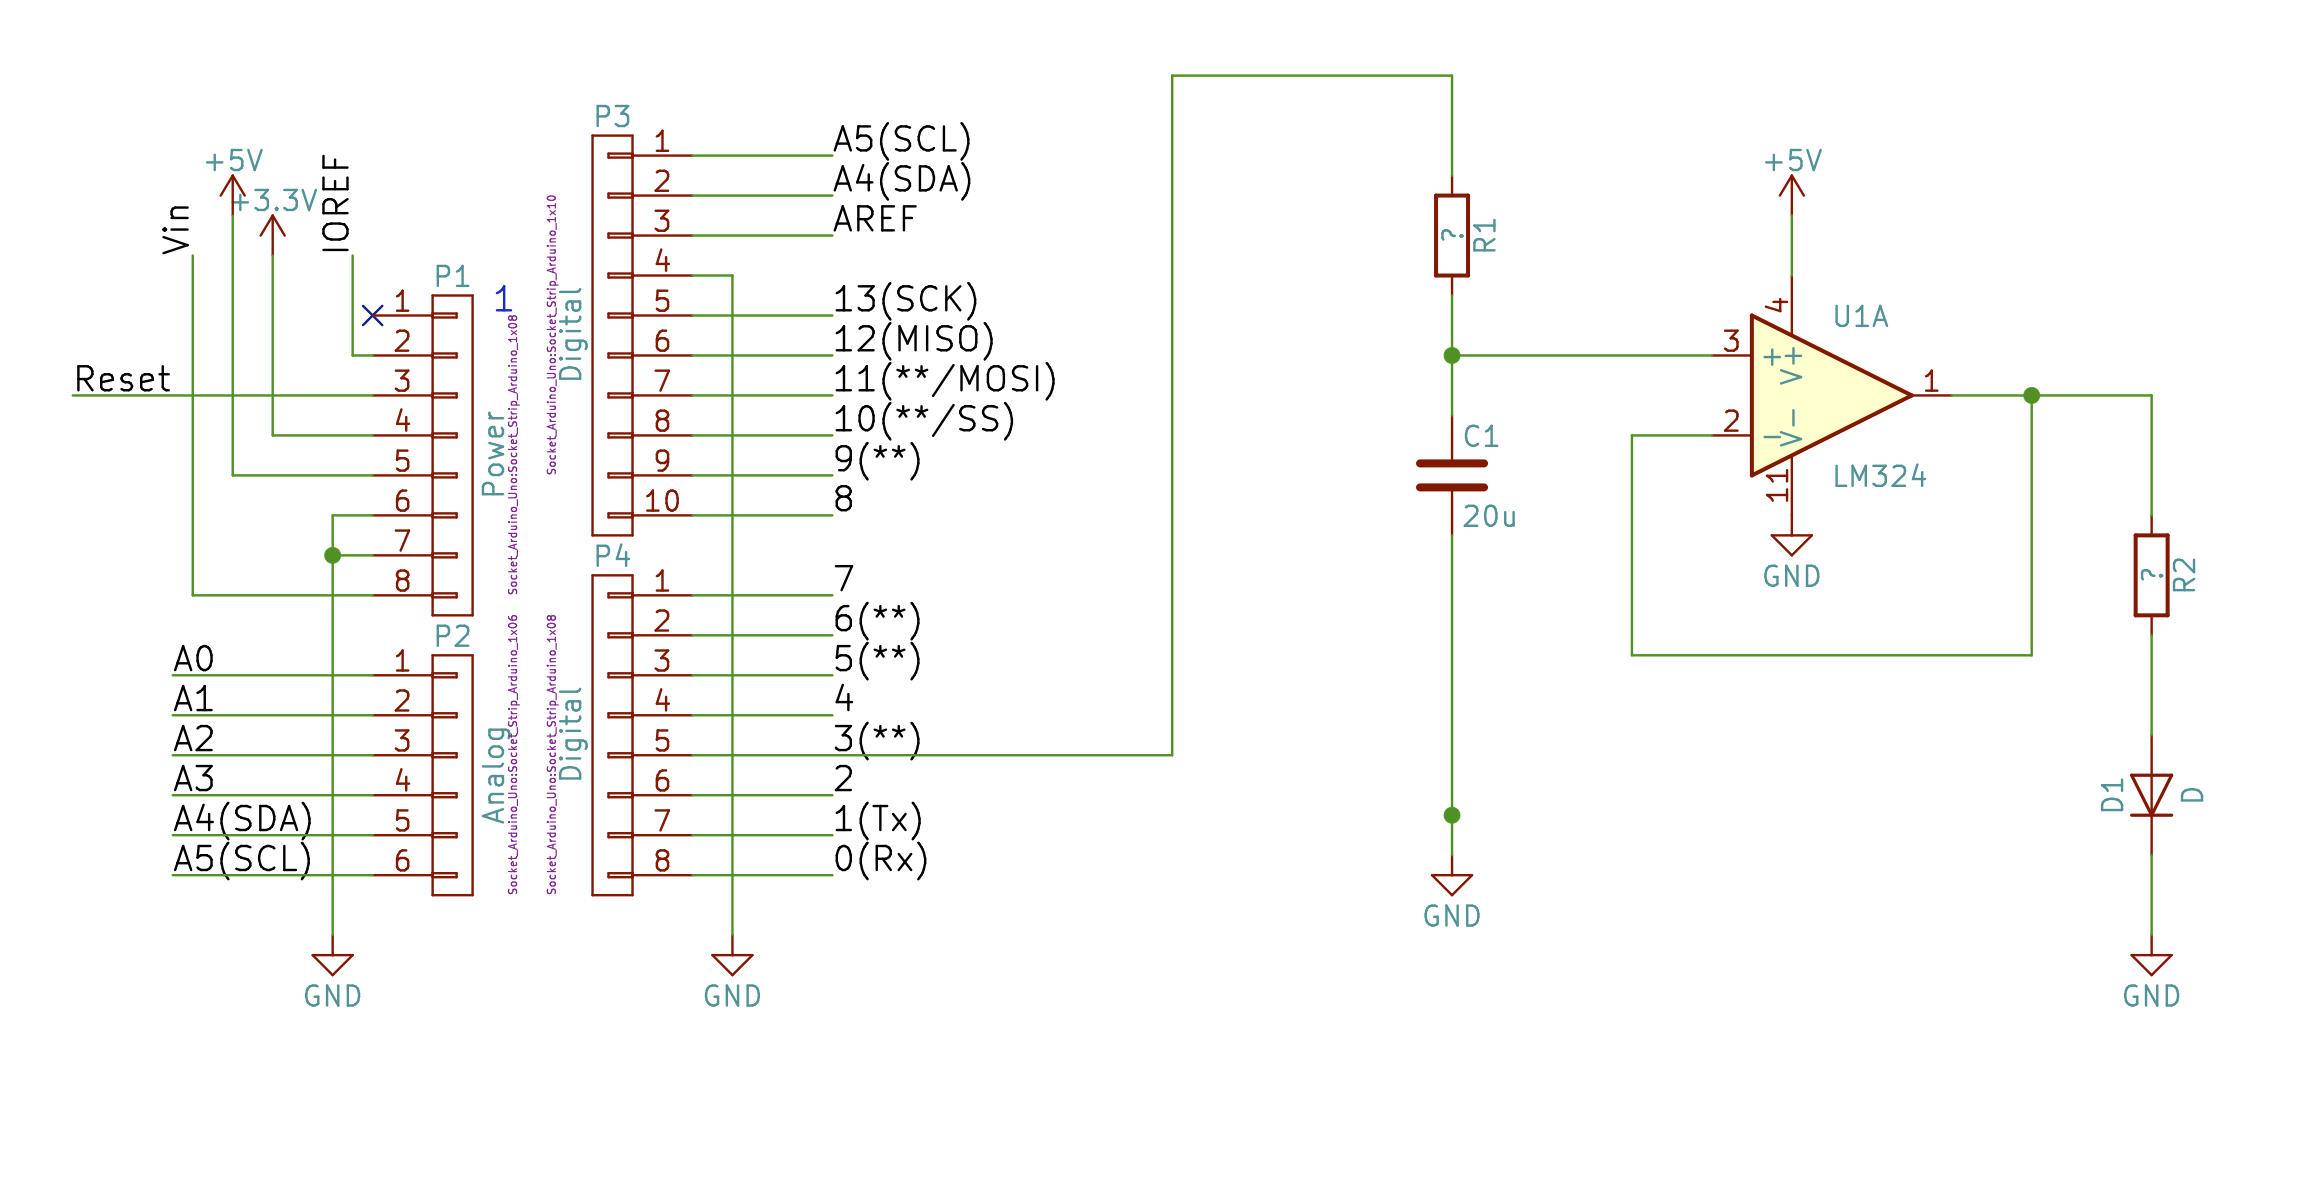

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as pl 
import numpy as np

df = pd.read_csv('data.csv')
df

FileNotFoundError: File b'data.csv' does not exist

How to measure the voltage across the diode and at the amplifier's output?

As shown in the picture above of the tinkercad simulation, the arduino has Analog pins that can be used to output the voltage. For the amplifier, the pin A0 is used and attached at the top of the resistor, in order to measure the voltage at the amplifier's output.
For the Diode, the pin A1 is used and connected at the bottom of the right hand's resistor. This will measure the voltage across the diode.
In other words:
i: This will be used as our time constant.
i2: The voltage measured at the top the resistor, which is the voltage of the amplifier's output.
i3: The voltage measured at the bottom of the resistor, which is the voltage across the diode.

###### This is a graph of i vs i1 and i vs i2: The evolution of the two voltages in time


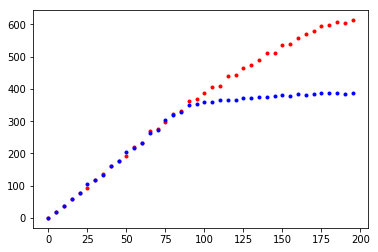

In [46]:
pl.plot(df.i,df.in1,'r.')
pl.plot(df.i,df.in2,'b.')

* The red dots represent the voltage across the amplifier. It keeps increasing with time. 
* The bliue dots reprent the voltage accross the diode. At the threshold voltage, it will start increasing very slowly.  

###### The following graph is the same as the previous one, but with different numbers.
* In fact, all the data under the columns in1 and in2 are not the actual voltages across the amplifier and the diode, respectively. We need to multiply by 5 and divide by 1023 to get the real voltages between 0 and 5V.

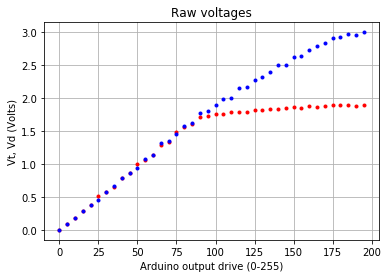

In [47]:
cnt = df.i.values
vd = df.in2.values*5.0/1023.0
vt = df.in1.values*5.0/1023.0
pl.title("Raw voltages")
pl.xlabel("Arduino output drive (0-255)")
pl.ylabel("Vt, Vd (Volts)")
pl.plot(cnt, vd, 'r.')
pl.plot(cnt,vt,'b.')
pl.grid()

###### Using Ohm's law, we can figure out the current through the diode. 
######            This is a graph of Diode's current vs Diode's voltage

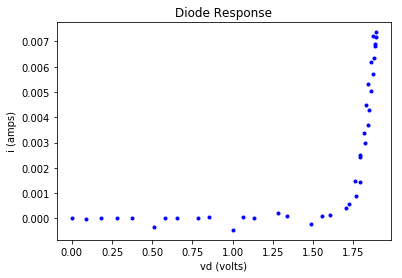

In [48]:
R = 150.0
vr = vt-vd
ir = vr/R
pl.title("Diode Response")
pl.xlabel("vd (volts)")
pl.ylabel("i (amps)")
pl.plot(vd,ir,'b.')

* As observed on the graph, the current starts increasing exponentially after reaching a certain value(Threshold). At +/- 1.75, the current is close to threshold. Within the next lines, we will be analyzing the current at that point.
##### The following two graphs shows the part of the curve where i = +/- 1.75 A and up.



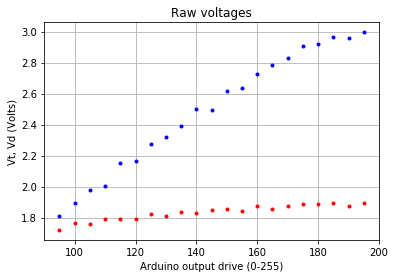

In [49]:
N = 19
cnt = df.i[N:].values
vd = df.in2[N:].values*5.0/1023.0
vt = df.in1[N:].values*5.0/1023.0
pl.title("Raw voltages")
pl.xlabel("Arduino output drive (0-255)")
pl.ylabel("Vt, Vd (Volts)")
pl.plot(cnt, vd, 'r.')
pl.plot(cnt,vt,'b.')
pl.grid()

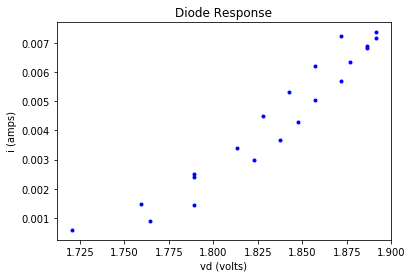

In [50]:
R = 150.0
vr = vt-vd
ir = vr/R
pl.title("Diode Response")
pl.xlabel("vd (volts)")
pl.ylabel("i (amps)")
pl.plot(vd,ir,'b.')

In order to obtain a fittin curve, we will need to develop the Shockley model and write a function that returns the voltage.

$$ I = I_o (e^{\frac{q V_d}{\eta k_b T}}-1) $$

After simplifications, we end up with the following form:

$$ V_{ext} = A \ln(I) + B + I C $$

with C = r

The following is the type of function needed to obtain a good fitting curve. 
def internal_R_model(I, A, B, C):
    return A*np.log(I) + C*I + B




In [51]:
from scipy.optimize import curve_fit
def internal_R_model(I, A, B, C):
    return A*np.log(I)+ C*I + B
A,B,C=0,0,0
par, cov = curve_fit(internal_R_model, ir, vd, p0=(A,B,0))
A,B,C = par
dA,dB,dC = np.sqrt(np.diag(cov))
print("A={:0} +/- {:1}".format(A,dA))
print("B={:0} +/- {:1}".format(B,dB))
print("C={:0} +/- {:1}".format(C,dC))

A=0.033497350476757816 +/- 0.011589819364848424
B=1.9750604096683597 +/- 0.08109275879141042
C=10.562807853391533 +/- 3.7618930089664784


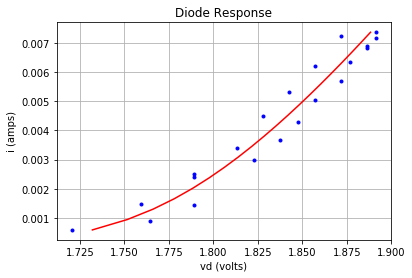

In [52]:
ith = np.linspace(min(ir),max(ir),20);ith
ystar = internal_R_model(ith,A,B,C)
pl.plot(ystar,ith,'r-')
pl.plot(vd, ir, 'b.')
pl.title("Diode Response")
pl.xlabel("vd (volts)")
pl.ylabel("i (amps)")
pl.grid()

#### STATISTICAL EXERCISES FOR PROJECT 1

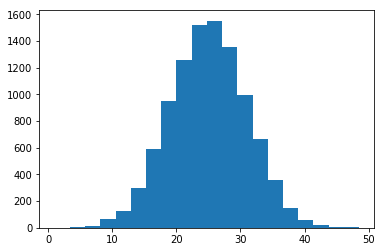

In [55]:
mu = 25
std = 6
N = 10000

dist1 = np.random.normal(loc=mu,scale = std, size = N)

hist1=pl.hist(dist1,bins=20)

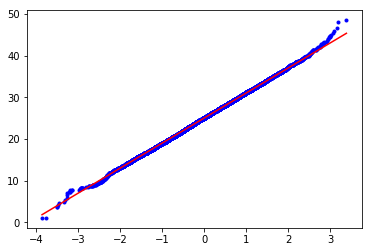

In [56]:
dist1 = np.array(sorted(dist1))
dist2 = np.array(sorted(np.random.normal(loc=0, scale=1.0, size=N)))

pl.plot(dist2,dist1,'b.')       
pl.plot(dist2, dist2*std + mu,'r-')


In [57]:
print("Pobability x>35 = ", len(dist1[dist1>35])/N)
print("Pobability(%) = ", len(dist1[dist1>35])/(N*0.01))

Pobability x>35 =  0.0454
Pobability(%) =  4.54


#### Conclusion

This lab had the purpose of familiarizing students with the most basic materials that will be used this semester. This circuit has two important materials that we worked on throughout this report, which are the diode and the amplifier. We observed the following: 
* After a certain amount of time, the values of the voltage across the diode and the resistor won't be similar anymore. In fact, after reaching threshold the voltage in the amplifier will keep increasing at the same rythm and the diode's voltage will be increasing at a much-slower rythm.
* The statistical exerci